In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axisartist.axislines import AxesZero

sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings, calc_cascaded_loadings
from loaders import load_sabes
from decoders import lr_decoder
from segmentation import reach_segment_sabes, measure_straight_dev  

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Calculate the top neurons dataframe, but keep track of the relative weighting in each subspace
dframe_indy = '/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat'
dframe_loco = '/mnt/Secondary/data/postprocessed/loco_decoding_df.dat'

print('Using dframes %s, %s' % (dframe_indy, dframe_loco))

with open(dframe_indy, 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)

with open(dframe_loco, 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        

DIM = 6

# Try the raw leverage scores instead
loadings_l = []
indy_data_files = np.unique(indy_df['data_file'].values)
for i, data_file in tqdm(enumerate(indy_data_files)):
    loadings = []
    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            df_ = apply_df_filters(indy_df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        
            loadings_fold.append(calc_loadings(V))


        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))

    d_ = {}
    d_['data_file'] = data_file
    d_['FCCA_loadings'] = loadings[0]
    d_['PCA_loadings'] = loadings[1]
    loadings_l.append(d_)                


loco_data_files = np.unique(loco_df['data_file'].values)
for i, data_file in tqdm(enumerate(loco_data_files)):
    loadings = []
    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            df_ = apply_df_filters(loco_df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            assert(df_.shape[0] == 1)
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        
            loadings_fold.append(calc_loadings(V))

        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))

    d_ = {}
    d_['data_file'] = data_file
    d_['FCCA_loadings'] = loadings[0]
    d_['PCA_loadings'] = loadings[1]
    loadings_l.append(d_)                

loadings_df = pd.DataFrame(loadings_l)

Using dframes /mnt/Secondary/data/postprocessed/indy_decoding_df2.dat, /mnt/Secondary/data/postprocessed/loco_decoding_df.dat


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
28it [00:00, 44.63it/s]
7it [00:00, 108.98it/s]


In [4]:
def quantile_fn(loadings, q):
    thresh = np.quantile(loadings, q)
    return set(list(np.argwhere(loadings >= thresh).squeeze()))

In [7]:
# There are two types of statistics. (1)is calculatd from each single unit PSTH (2) relies on a distribution of pairwise comparisons
# To obtain a gradient of contrasts for (1) is straightforward, as one fixes quantie 1, and evaluates the statistic as a function of quantile 2
# To obtain a gradient of contrasts of (2), we fix quantile 1 and then sort in descending order by the other quantile, but bin at some quantile bin width

In [26]:
# (Bin size 50 ms)
T = 30

time = 50 * np.arange(T)
data_path = '/mnt/Secondary/data/sabes'
data_files = np.unique(loadings_df['data_file'].values)
quantiles = np.arange(0, 1, 0.1)
dyn_range = np.zeros((len(data_files),), dtype=object)

for h, data_file in enumerate(data_files):
    df_ = apply_df_filters(loadings_df, data_file=data_file)
    dat = load_sabes('%s/%s' % (data_path, data_file), boxcox=None, high_pass=False)
    dat_segment = reach_segment_sabes(dat, data_file=data_file.split('.mat')[0])
    
    t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
    valid_transitions = np.arange(t.size)[t >= T]
    dr = np.zeros((3, df_.iloc[0]['PCA_loadings'].size))

    dr[0, :] = df_.iloc[0]['PCA_loadings']
    dr[1, :] = df_.iloc[0]['FCCA_loadings']

    x = np.zeros((df_.iloc[0]['PCA_loadings'].size, time.size))
    for j in range(x.shape[0]):
        x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, j] 
                        for idx in valid_transitions])
        x_ = StandardScaler().fit_transform(x_.T).T
        x_ = gaussian_filter1d(x_, sigma=2)
        x_ = np.mean(x_, axis=0)
        dr[2, j] = np.max(x_)

    dyn_range[h] = dr

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size
Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [35]:
feautures = dyn_range[0]
for k in range(1, dyn_range.size):
    features = np.hstack([features, dyn_range[k]])

<BarContainer object of 50 artists>

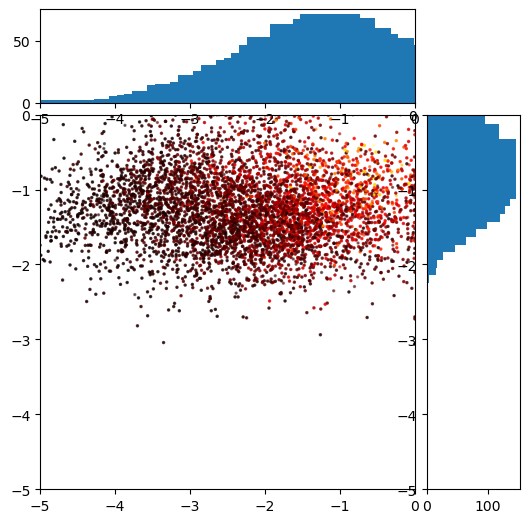

In [58]:
# 2D histogram of dynamic range vs. leverage scores
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax.set_ylim([-5, 0])
ax.set_xlim([-5, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.scatter(np.log10(features[0, :]), np.log10(features[1, :]), c=features[2, :], s=2, alpha=0.5, cmap='hot')

# Take the weighted sum along each axis
bins = np.linspace(-5, 0)
_, _, hist_pca_idxs = scipy.stats.binned_statistic(np.log10(features[0, :]), None, statistic='count', bins=bins)
_, _, hist_fca_idxs = scipy.stats.binned_statistic(np.log10(features[1, :]), None, statistic='count', bins=bins)

pca_sums = np.zeros(bins.size)
fca_sums = np.zeros(bins.size)
for idx in range(bins.size):
    pca_sums[idx] = np.sum(features[2, np.argwhere(hist_pca_idxs == idx).squeeze()])
    fca_sums[idx] = np.sum(features[2, np.argwhere(hist_fca_idxs == idx).squeeze()])

ax_histx.bar(bins, pca_sums, align='edge')
ax_histy.barh(bins, fca_sums, align='edge')

In [32]:
from sklearn.mixture import GaussianMixture

In [33]:
features = dyn_range[0]
for k in range(1, dyn_range.size):
    features = np.hstack([features, dyn_range[k]])

### Fit a joint model of the marginal statistics and assess predictability

In [27]:
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import QuantileRegressor, LinearRegression

In [5]:
DIM = 6

# Try the raw leverage scores instead
loadings_l = []
indy_data_files = np.unique(indy_df['data_file'].values)
for i, data_file in tqdm(enumerate(indy_data_files)):
    loadings = []
    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            df_ = apply_df_filters(indy_df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        
            loadings_fold.append(calc_loadings(V))


        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))

    for j in range(loadings[0].size):
        d_ = {}
        d_['data_file'] = data_file
        d_['FCCA_loadings'] = loadings[0][j]
        d_['PCA_loadings'] = loadings[1][j]
        # d_['DCA_loadings'] = loadings[2][j]
        d_['nidx'] = j
        loadings_l.append(d_)                

loco_data_files = np.unique(loco_df['data_file'].values)
for i, data_file in tqdm(enumerate(loco_data_files)):
    loadings = []
    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            df_ = apply_df_filters(loco_df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            assert(df_.shape[0] == 1)
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        
            loadings_fold.append(calc_loadings(V))

        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))

    for j in range(loadings[0].size):
        d_ = {}
        d_['data_file'] = data_file
        d_['FCCA_loadings'] = loadings[0][j]
        d_['PCA_loadings'] = loadings[1][j]
        # d_['DCA_loadings'] = loadings[2][j]
        d_['nidx'] = j
        loadings_l.append(d_)                

loadings_df = pd.DataFrame(loadings_l)

28it [00:00, 39.30it/s]
7it [00:00, 111.53it/s]


In [6]:
with open('/mnt/Secondary/data/postprocessed/sabes_su_calcs.dat', 'rb') as f:
    sabes_su_l = pickle.load(f)

sabes_su_df = pd.DataFrame(sabes_su_l)

In [7]:
def get_scalar(df_, stat, neu_idx):

    if stat == 'decoding_weights':
        decoding_win = df_.iloc[0]['decoder_params']['decoding_window']
        # Restrict to velocity decoding
        c = calc_loadings(df_.iloc[0]['decoding_weights'][2:4].T, d=decoding_win)[neu_idx]
    elif stat == 'encoding_weights':
        decoding_win = df_.iloc[0]['decoder_params']['decoding_window']
        c =  calc_loadings(df_.iloc[0]['encoding_weights'], d=decoding_win)[neu_idx]        
    elif stat in ['su_r2_pos', 'su_r2_vel', 'su_r2_enc', 'su_var', 'su_act']:
        c = df_.iloc[0][stat][neu_idx]  
    elif stat == 'orientation_tuning':
        c = np.zeros(8)
        for j in range(8):
            c[j] = df_.loc[df_['bin_idx'] == j].iloc[0]['tuning_r2'][j, 2, neu_idx]
        c = np.mean(c)
        # c = odf_.iloc[0]
    return c

In [8]:

# Dimensionality selection
itrim_df = loadings_df
data_files = np.unique(itrim_df['data_file'].values)

# Collect the desired single unit statistics into an array with the same ordering as those present in the loadings df
stats = ['su_var', 'su_act', 'decoding_weights', 'su_r2_enc']

carray = []
lpc = []
lfc = []
for i, data_file in enumerate(data_files):
    df = apply_df_filters(itrim_df, data_file=data_file)
    carray_ = np.zeros((df.shape[0], len(stats)))
    
    ldings_p = np.zeros(df.shape[0])
    ldings_f = np.zeros(df.shape[0])
    
    for j in range(df.shape[0]):                    # Find the correlation between 
        for k, stat in enumerate(stats):
            ldings_p[j] = df.iloc[j]['PCA_loadings']
            ldings_f[j] = df.iloc[j]['FCCA_loadings']

            # Grab the unique identifiers needed
            nidx = df.iloc[j]['nidx']
            
            if stat == 'orientation_tuning':
                df_ = apply_df_filters(odf, file=data_file, tau=4)
            else:
                df_ = apply_df_filters(sabes_su_df, data_file=data_file)
            carray_[j, k] = get_scalar(df_, stat, nidx)
    carray.append(carray_)
    lpc.append(ldings_p)
    lfc.append(ldings_f)

In [9]:
X = carray[0]
for k in range(1, len(carray)):
    X = np.vstack([X, carray[k]])

Yp = lpc[0][:, np.newaxis]
for k in range(1,len(lpc)):
    Yp = np.vstack([Yp, lpc[k][:, np.newaxis]])

Yf = lfc[0][:, np.newaxis]
for k in range(1, len(lfc)):
    Yf = np.vstack([Yf, lfc[k][:, np.newaxis]])

In [10]:
quantiles = np.arange(0.05, 1, 0.05)

# The evaluation metric is the mismatch between predicted quantile and the actual quantile 

trainr = np.zeros((5, 2, quantiles.size))
testr = np.zeros((5, 2, quantiles.size))

In [11]:
import statsmodels

In [24]:
model = QuantileRegressor(quantile=0.5, alpha=0, solver='highs-ds').fit(X, np.log10(Yp).squeeze())

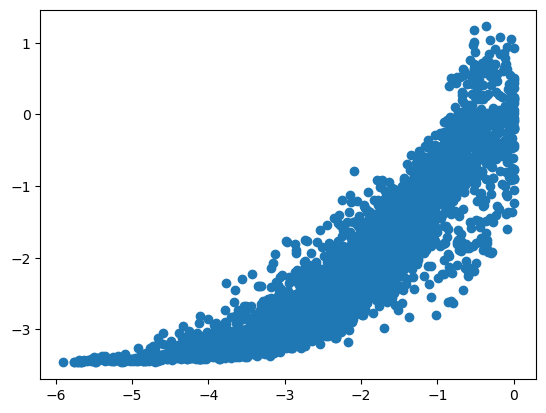

In [18]:
plt.scatter(np.log10(Yp).squeeze(), model.predict(X))

In [19]:
model = QuantileRegressor(quantile=0.5, alpha=0, solver='highs-ds').fit(X, np.log10(Yf).squeeze())

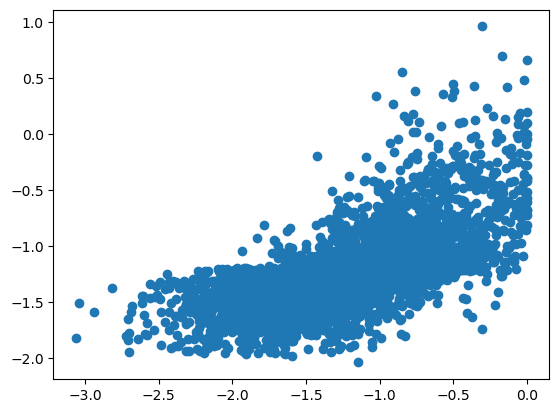

In [20]:
plt.scatter(np.log10(Yf).squeeze(), model.predict(X))

In [25]:
np.median(model.predict(X))

-2.4302244486002436

In [26]:
np.median(np.log10(Yp))

-2.21956021108833

In [29]:
# Do in a cross-validated way
quantiles = np.arange(0.05, 1, 0.05)

# The evaluation metric is the mismatch between predicted quantile and the actual quantile 
trainq = np.zeros((5, 2, quantiles.size))
testq = np.zeros((5, 2, quantiles.size))

# spearman-r between predicted and actual values
trainr = np.zeros((5, 2, quantiles.size))
testr = np.zeros((5, 2, quantiles.size))


for i, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5).split(X)):
    xtrain = X[train_idxs]
    xtest = X[test_idxs]

    ytrain = Yp[train_idxs]
    ytest = Yp[test_idxs]

    for j, q in enumerate(quantiles):
        model = QuantileRegressor(quantile=0.5, alpha=0, solver='highs-ds').fit(xtrain, ytrain.squeeze())
        yptr = model.predict(xtrain)
        ypte = model.predict(xtest)

        trainr[i, 0, j] = scipy.stats.spearmanr(ytrain, yptr)[0]
        testr[i, 0, j] = scipy.stats.spearmanr(ytest, ypte)[0]

        yq = np.quantile(yptr, q)
        # What is the effective quantile represented by this value?
        q_ = sum(np.abs(ytrain.squeeze()) < yq)/float(len(ytrain))

        trainq[i, 0, j] = q_ - q

        yq = np.quantile(ypte, q)
        # What is the effective quantile represented by this value?
        q_ = sum(np.abs(ytest.squeeze()) < yq)/float(len(ytest))

        testq[i, 0, j] = q_ - q


    ytrain = Yf[train_idxs]
    ytest = Yf[test_idxs]
    
    for j, q in enumerate(quantiles):
        model = QuantileRegressor(quantile=0.5, alpha=0, solver='highs-ds').fit(xtrain, ytrain.squeeze())
        yptr = model.predict(xtrain)
        ypte = model.predict(xtest)

        trainr[i, 1, j] = scipy.stats.spearmanr(ytrain, yptr)[0]
        testr[i, 1, j] = scipy.stats.spearmanr(ytest, ypte)[0]

        yq = np.quantile(yptr, q)
        # What is the effective quantile represented by this value?
        q_ = sum(np.abs(ytrain.squeeze()) < yq)/float(len(ytrain))

        trainq[i, 1, j] = q_ - q

        yq = np.quantile(ypte, q)
        # What is the effective quantile represented by this value?
        q_ = sum(np.abs(ytest.squeeze()) < yq)/float(len(ytest))

        testq[i, 1, j] = q_ - q


In [32]:
trainr[:, 0, :].ravel()

array([0.93863504, 0.93863504, 0.93863504, 0.93863504, 0.93863504,
       0.93863504, 0.93863504, 0.93863504, 0.93863504, 0.93863504,
       0.93863504, 0.93863504, 0.93863504, 0.93863504, 0.93863504,
       0.93863504, 0.93863504, 0.93863504, 0.93863504, 0.93367474,
       0.93367474, 0.93367474, 0.93367474, 0.93367474, 0.93367474,
       0.93367474, 0.93367474, 0.93367474, 0.93367474, 0.93367474,
       0.93367474, 0.93367474, 0.93367474, 0.93367474, 0.93367474,
       0.93367474, 0.93367474, 0.93367474, 0.92909307, 0.92909307,
       0.92909307, 0.92909307, 0.92909307, 0.92909307, 0.92909307,
       0.92909307, 0.92909307, 0.92909307, 0.92909307, 0.92909307,
       0.92909307, 0.92909307, 0.92909307, 0.92909307, 0.92909307,
       0.92909307, 0.92909307, 0.93576243, 0.93576243, 0.93576243,
       0.93576243, 0.93576243, 0.93576243, 0.93576243, 0.93576243,
       0.93576243, 0.93576243, 0.93576243, 0.93576243, 0.93576243,
       0.93576243, 0.93576243, 0.93576243, 0.93576243, 0.93576

In [34]:
trainr[:,1, :].ravel()

array([0.67910815, 0.67910815, 0.67910815, 0.67910815, 0.67910815,
       0.67910815, 0.67910815, 0.67910815, 0.67910815, 0.67910815,
       0.67910815, 0.67910815, 0.67910815, 0.67910815, 0.67910815,
       0.67910815, 0.67910815, 0.67910815, 0.67910815, 0.68926746,
       0.68926746, 0.68926746, 0.68926746, 0.68926746, 0.68926746,
       0.68926746, 0.68926746, 0.68926746, 0.68926746, 0.68926746,
       0.68926746, 0.68926746, 0.68926746, 0.68926746, 0.68926746,
       0.68926746, 0.68926746, 0.68926746, 0.69084694, 0.69084694,
       0.69084694, 0.69084694, 0.69084694, 0.69084694, 0.69084694,
       0.69084694, 0.69084694, 0.69084694, 0.69084694, 0.69084694,
       0.69084694, 0.69084694, 0.69084694, 0.69084694, 0.69084694,
       0.69084694, 0.69084694, 0.68826437, 0.68826437, 0.68826437,
       0.68826437, 0.68826437, 0.68826437, 0.68826437, 0.68826437,
       0.68826437, 0.68826437, 0.68826437, 0.68826437, 0.68826437,
       0.68826437, 0.68826437, 0.68826437, 0.68826437, 0.68826